In [224]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

1163.png
X:\Mask_detection_dataset\Test\WithMask
X:\Mask_detection_dataset\Test\WithMask\1163.png


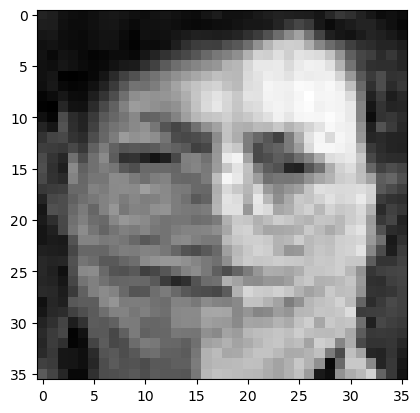

In [225]:
Datadir = "X:\Mask_detection_dataset\Train"
Categories= ["WithMask","WithoutMask"]
Datadir_test = "X:\Mask_detection_dataset\Test"
for category in Categories:
    path = os.path.join(Datadir_test,category)
    for img in os.listdir(path):
        print(img)
        print(path)
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        print(os.path.join(path,img))
        plt.imshow(img_array,cmap="gray")
        plt.show()
        break
    break

In [226]:
print(img_array.shape)

(36, 36)


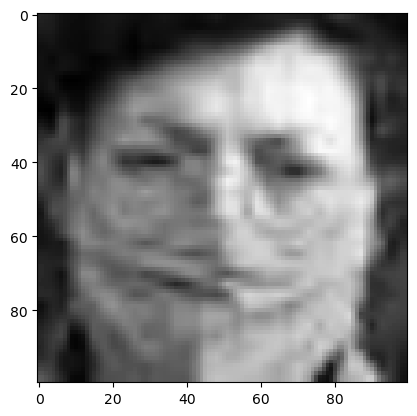

In [227]:
IMG_SIZE= 100

new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap = 'gray')
plt.show()

In [228]:
training_data = []

def create_training_data():
    for category in Categories:
        path= os.path.join(Datadir, category)
        class_num = Categories.index(category)
        for img in os.listdir(path):
            try:
                img_array= cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
            
create_training_data()

In [229]:
testing_data = []

def create_testing_data():
    for category in Categories:
        path= os.path.join(Datadir_test, category)
        class_num = Categories.index(category)
        for img in os.listdir(path):
            try:
                img_array= cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
                testing_data.append([new_array,class_num])
            except Exception as e:
                pass
            
create_testing_data()

In [230]:
print(len(training_data))

10000


In [231]:
print(len(testing_data))

992


In [232]:
path

'X:\\Mask_detection_dataset\\Test\\WithMask'

In [233]:
import random

random.shuffle(training_data)
random.shuffle(testing_data)

In [234]:
for sample in training_data[:10]:
    print(sample[1])

1
1
0
0
1
1
0
0
0
0


In [235]:
X_train = []
y_train = []
X_test = []
y_test = []

In [236]:
for features, label in training_data:
    X_train.append(features)
    y_train.append(label)
    
for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)
    
#X_train = np.array(X_train)
#X_test = np.array(X_test)
X_train = np.array(X_train).reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_test = np.array(X_test).reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_train = np.array(X_train)/255.0
X_test= np.array(X_test)/255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

In [237]:
print(X_train.shape)
print(y_train.shape)

(10000, 1, 100, 100)
(10000,)


In [238]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [239]:
class CNN(nn.Module):
    def __init__(self,in_channels=1,num_classes=2):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels=8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.fc1 = nn.Linear(16*25*25, num_classes)
        
        
    def forward(self,x):
        x = F.relu(self.conv1(x.float()))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        
        return x
    
model = CNN()
x = torch.rand(64,1,100,100)
print(model(x).shape)

torch.Size([64, 2])


In [240]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels = 1
out_channels = 2
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [241]:
class MaskData(Dataset):
    def __init__(self,x,y,transforms = None):
        self.X = x
        self.Y = y
        self.transforms = transforms
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self,index):
        x = torch.tensor(self.X[index,:,:])
        y = torch.tensor(self.Y[index])
        
        return x,y

In [242]:
train_set = MaskData(X_train, y_train)
test_set = MaskData(X_test,y_test)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size= batch_size*4)

In [243]:
model = CNN()

In [244]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [245]:
for epoch in range(num_epochs):
    print(f'current epoch number: {epoch}')
    for batch_idx, (data,targets) in enumerate(train_loader):
        data = data.to(device = device)
        targets = targets.to(device = device).long()
        scores = model(data)
        loss = criterion(scores,targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

current epoch number: 0
current epoch number: 1
current epoch number: 2
current epoch number: 3
current epoch number: 4
current epoch number: 5
current epoch number: 6
current epoch number: 7
current epoch number: 8
current epoch number: 9


In [246]:
def check_accuracy(loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _,prediction = scores.max(1)
            num_correct += (prediction == y).sum()
            num_samples += prediction.size(0)
            
            print(f'Got {num_correct}/{num_samples} with accuracy {float (num_correct)/float(num_samples)*100:.2f}')
    model.train()
    
check_accuracy(train_loader,model)
check_accuracy(test_loader,model)

Got 64/64 with accuracy 100.00
Got 128/128 with accuracy 100.00
Got 192/192 with accuracy 100.00
Got 255/256 with accuracy 99.61
Got 319/320 with accuracy 99.69
Got 383/384 with accuracy 99.74
Got 447/448 with accuracy 99.78
Got 509/512 with accuracy 99.41
Got 573/576 with accuracy 99.48
Got 635/640 with accuracy 99.22
Got 699/704 with accuracy 99.29
Got 762/768 with accuracy 99.22
Got 824/832 with accuracy 99.04
Got 887/896 with accuracy 99.00
Got 950/960 with accuracy 98.96
Got 1012/1024 with accuracy 98.83
Got 1076/1088 with accuracy 98.90
Got 1140/1152 with accuracy 98.96
Got 1203/1216 with accuracy 98.93
Got 1267/1280 with accuracy 98.98
Got 1331/1344 with accuracy 99.03
Got 1394/1408 with accuracy 99.01
Got 1458/1472 with accuracy 99.05
Got 1520/1536 with accuracy 98.96
Got 1581/1600 with accuracy 98.81
Got 1645/1664 with accuracy 98.86
Got 1708/1728 with accuracy 98.84
Got 1767/1792 with accuracy 98.60
Got 1829/1856 with accuracy 98.55
Got 1893/1920 with accuracy 98.59
Got 1957/

In [247]:
import pickle
with open('CNN_pickle','wb') as f:
    pickle.dump(model,f)
    
with open('CNN_pickle','rb') as f:
    mp = pickle.load(f)

In [248]:
import joblib
joblib.dump(model,'CNN_joblib')
mj = joblib.load('CNN_joblib')

ModuleNotFoundError: No module named 'joblib'